<a href="https://colab.research.google.com/github/ishan97-hash/Object-Detection/blob/main/SDD_Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [ ]:
import tensorflow as tf
from VGG16_custom.custom_vgg16_pretrained import VGG16
from VGG16_custom import *
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Dropout
from tensorflow.keras.layers import concatenate
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
base_vgg16 = VGG16(input_shape=(300,300,3))

In [ ]:
weights = np.load('VGG16_custom/imagenet.npy', allow_pickle=True)
base_vgg16.set_weights(weights)
base_vgg16.trainable = False

In [ ]:
base_vgg16.summary()

Model: "Base_VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1_1 (Conv2D)             (None, 300, 300, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 300, 300, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 150, 150, 64)      0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 150, 150, 128)     73856     
_________________________________________________________________
Conv2_2 (Conv2D)             (None, 150, 150, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 75, 75, 128)       0         
_________________________________________________________________
Conv3_1 (Conv2D)             (None, 75, 75, 256)       2

In [ ]:
def add_feature_layers():
    block5_conv3 = base_vgg16.get_layer('Conv5_3').output
    block5_conv3.shape

    Conv6 = Conv2D(filters=1024,kernel_size=(3,3),padding='same', name='Conv6', activation='relu')(block5_conv3)
    Conv7 = Conv2D(filters=1024,kernel_size=(1,1),strides=(1,1), name='Conv7', activation='relu')(Conv6)
    #Conv7.shape

    Conv8_1 = Conv2D(filters=256,kernel_size=(1,1),name='Conv8_1', activation='relu')(Conv7)
    Conv8_2 = Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=(2,2),name='Conv8_2', activation='relu')(Conv8_1)
    #Conv8_2.shape

    Conv9_1 = Conv2D(filters=128,kernel_size=(1,1),name='Conv9_1', activation='relu')(Conv8_2)
    Conv9_2 = Conv2D(filters=256,kernel_size=(3,3),strides=(2,2),padding='same',name='Conv9_2', activation='relu')(Conv9_1)
    #Conv9_2.shape

    Conv10_1 = Conv2D(filters=128,kernel_size=(1,1),name='Conv10_1', activation='relu')(Conv9_2)
    Conv10_2 = Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),name='Conv10_2', activation='relu')(Conv10_1)
    #Conv10_2.shape

    Conv11_1 = Conv2D(filters=128,kernel_size=(1,1),name='Conv11_1', activation='relu')(Conv10_2)
    Conv11_2 = Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),name='Conv11_2', activation='relu')(Conv11_1)
    #Conv11_2.shape

    features_model = tf.keras.models.Model(inputs=base_vgg16.input,outputs=Conv11_2, name='Features')

    return features_model

In [ ]:
features_model = add_feature_layers()

In [ ]:
features_model.summary()

Model: "Features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      [(None, 300, 300, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 300, 300, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 300, 300, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 150, 150, 64)      0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 150, 150, 128)     73856     
_________________________________________________________________
Conv2_2 (Conv2D)             (None, 150, 150, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 75, 75, 128)       0  

In [ ]:
num_classes = 21

In [ ]:
out_class = [Conv2D(filters=4*num_classes,kernel_size=(3,3),padding='SAME')(features_model.get_layer('Conv4_3').output),
              Conv2D(filters=6*num_classes,kernel_size=(3,3),padding='SAME')(features_model.get_layer('Conv7').output),
              Conv2D(filters=6*num_classes,kernel_size=(3,3),padding='SAME')(features_model.get_layer('Conv8_2').output),
              Conv2D(filters=6*num_classes,kernel_size=(3,3),padding='SAME')(features_model.get_layer('Conv9_2').output),
              Conv2D(filters=4*num_classes,kernel_size=(3,3),padding='SAME')(features_model.get_layer('Conv10_2').output),
              Conv2D(filters=4*num_classes,kernel_size=(1,1),padding='SAME')(features_model.get_layer('Conv11_2').output)]

out_loc = [Conv2D(filters=4*4,kernel_size=(3,3),padding='SAME')(features_model.get_layer('Conv4_3').output),
           Conv2D(filters=6*4,kernel_size=(3,3),padding='SAME')(features_model.get_layer('Conv7').output),
           Conv2D(filters=6*4,kernel_size=(3,3),padding='SAME')(features_model.get_layer('Conv8_2').output),
           Conv2D(filters=6*4,kernel_size=(3,3),padding='SAME')(features_model.get_layer('Conv9_2').output),
           Conv2D(filters=4*4,kernel_size=(3,3),padding='SAME')(features_model.get_layer('Conv10_2').output),
           Conv2D(filters=4*4,kernel_size=(3,3),padding='SAME')(features_model.get_layer('Conv11_2').output)]

In [ ]:
ssd_model = tf.keras.models.Model(inputs=base_vgg16.input,outputs=out_class+out_loc,name='SSD_Model')

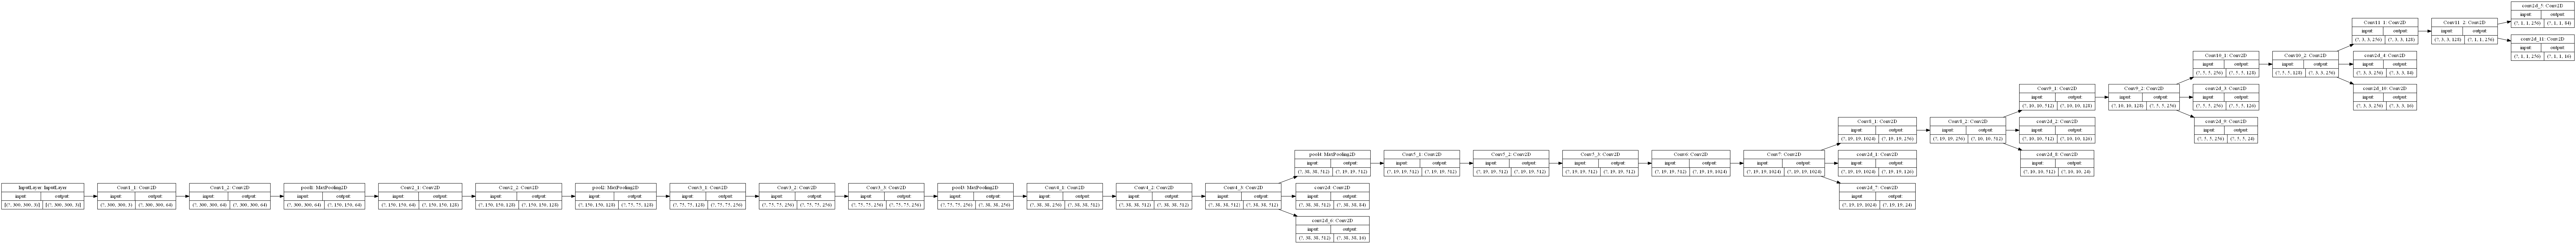

In [ ]:
tf.keras.utils.plot_model(ssd_model,to_file='SSD.png',show_layer_names=True,show_shapes=True, rankdir='LR', expand_nested=True, dpi=100)

In [ ]:
ssd_model.output_shape

[(None, 38, 38, 84),
 (None, 19, 19, 126),
 (None, 10, 10, 126),
 (None, 5, 5, 126),
 (None, 3, 3, 84),
 (None, 1, 1, 84),
 (None, 38, 38, 16),
 (None, 19, 19, 24),
 (None, 10, 10, 24),
 (None, 5, 5, 24),
 (None, 3, 3, 16),
 (None, 1, 1, 16)]

In [ ]:
img = plt.imread('flamingo1.jfif')

In [ ]:
img = img.reshape((1,)+img.shape)

In [ ]:
output = ssd_model.predict(img)

In [ ]:
len(output)

12

In [ ]:
output[1].shape

(1, 19, 19, 126)

In [ ]:
a = np.random.random((1,1,1,21))

In [ ]:
i = 0

In [ ]:
output1 = output[i].reshape((output[i].shape[-1]//21*output[i].shape[0],) + output[i].shape[1:3] +(21,))

In [ ]:
output1 - a

array([[[[-1.35149121e+02,  1.86343605e+02, -2.63599173e+01, ...,
           5.08953743e+01,  5.94142812e+01,  1.67606450e+02],
         [-4.42518661e+01, -1.09047554e+02,  2.40341510e+02, ...,
           5.25809672e+00, -7.40699527e+01, -1.18164020e+02],
         [ 9.25338165e+01, -1.32469856e+02, -1.58195092e+01, ...,
          -6.58748894e+01,  7.62400067e+01,  4.90169609e+01],
         ...,
         [-1.42327774e+01, -7.60652710e+00, -5.02956320e+01, ...,
           6.69725685e+01,  2.71252911e+01, -4.09747726e+01],
         [ 3.98041172e+00,  5.54102404e+01, -1.00945286e+02, ...,
           8.85600929e+01, -3.36550586e+01,  1.03856923e+02],
         [-8.73647430e+01, -9.70450437e+01,  4.50050691e+01, ...,
          -1.07745931e+00, -7.17351982e+00, -6.07587769e+01]],

        [[-3.13271168e+01, -4.46364210e+01, -3.60235144e+01, ...,
           1.93039208e+01, -6.07540812e-01,  9.39505280e+01],
         [-1.21412151e+01, -7.48920227e+00, -4.72929846e+01, ...,
           6.62144966e